In [90]:
import pickle
import os
import numpy as np

combined_dataset = []

# Specify the directory path (replace '.' with your directory path if needed)
directory = '.'

# List all files starting with 'dataset_' and ending with '.pkl'
dataset_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('dataset_') and f.endswith('.pkl')]

for file in dataset_files:
    print(f'Loading {file}...')
    try:
        with open(file, 'rb') as f:
            d = pickle.load(f)
            # Ensure d is a list or array-like before extending
            if isinstance(d, (list, np.ndarray)):
                combined_dataset.extend(d)
            else:
                print(f"Warning: {file} does not contain a list or array-like data, skipping.")
    except Exception as e:
        print(f"Error loading {file}: {e}")

print(f"Total length of combined dataset: {len(combined_dataset)}")

Loading dataset_8501c8ec60bc4766a35c2e30eaf42b28.pkl...
Loading dataset_582c3021631e4b8890518c458a83b560.pkl...
Loading dataset_8476930f9a894802b477e26e5db5813f.pkl...
Loading dataset_26d5937541f34de4ad13acc1ea42b9d7.pkl...
Total length of combined dataset: 4


In [91]:
import torch
import torch.nn as nn

class LSTM(nn.Module):
    """LSTM unit for regression"""

    def __init__(self, input_size, output_size, hidden_size, num_layers, drop_out=0.1):
        super().__init__()

        self.input_size = input_size    # Number of features per time step
        self.output_size = output_size  # Number of output features
        self.hidden_size = hidden_size  # Size of hidden state
        self.num_layers = num_layers    # Number of LSTM layers
        self.drop_out = drop_out        # Dropout probability

        self.lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,           # Input shape: (batch_size, seq_len, input_size)
            dropout=self.drop_out if self.num_layers > 1 else 0.0,  # Dropout only if >1 layer
        )

        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, self.output_size),  # Maps hidden state to output
        )

    def forward(self, x):
        """out: [batch_size, seq_len, hidden_size]"""
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))          # LSTM output: (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])             # Take last time step, shape: (batch_size, output_size)
        return out.squeeze(-1)

In [92]:
import numpy as np

WINDOWS_SIZE = 10
X_list = []
y_list = []
for data in combined_dataset:
    y = data['y']
    n_samples = len(data['xs']['l2'])
    # print(n_samples)
    for j in range(WINDOWS_SIZE, n_samples - 2):        
        l2s = data['xs']['l2']
        fhs = data['xs']['fh']

        x_l2 = l2s[j - WINDOWS_SIZE + 1 : j + 1][['phr', 'wb_cqi', 'pusch_snr', 'rsrp']].to_numpy() / np.array([100, 20, 30, -150])
        # print(x_l2)

        timestamp = l2s.iloc[j]['TsTaiNs']
        # print(timestamp)
        valid_rows = fhs[fhs['TsTaiNs'] <= timestamp].copy()
        # print(valid_rows)
        
        # Sort by timestamp in descending order to get the most recent first
        valid_rows = valid_rows.sort_values(by='TsTaiNs', ascending=False)
        # Take the top n rows (or fewer if not enough rows exist)
        result = valid_rows.head(WINDOWS_SIZE)
        # Sort the result in ascending order for chronological presentation
        result = result.sort_values(by='TsTaiNs', ascending=True)
        # print(result)
        x_fh_grid = result['fhData'].to_numpy()
        # print(x_fh_grid[0])
        x_fh = []
        for x in x_fh_grid:
            x = x.reshape(-1)
            real_part = np.real(x)
            imag_part = np.imag(x)
            paired_array = np.stack((real_part, imag_part), axis=-1)
            x = paired_array.reshape(-1)
            x_fh.append(x)
        # print(x_fh[0].shape)
        if len(x_fh) != WINDOWS_SIZE:
            print("Ignore")
            continue
        x = [list(x) + list(y) for x, y in zip(x_l2, x_fh)]
        # print(len(x))
        # print(x[0])
        
        X_list.append(x)
        y_list.append(y)
    #     break
    # break

print(len(X_list))
print(len(X_list[0]))
print(len(y_list))

Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
Ignore
26792
10
26792


In [94]:
X_torch = torch.tensor(X_list, dtype=torch.float32)
X_torch.shape
y_torch = torch.tensor(y_list, dtype=torch.float32)
y_torch.shape

torch.Size([26792])

In [95]:
import heapq
import datetime

# Check platform.
import platform
if platform.machine() not in ['x86_64', 'aarch64']:
    raise SystemExit("Unsupported platform!")

import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connecting to clickhouse on remote server
import clickhouse_connect

# Import the channel estimator and some utilities for converting
# the DMRS fields in the right format from the SCF FAPI format that the dataset follows.
from aerial.phy5g.algorithms import ChannelEstimator
from aerial.util.fapi import dmrs_fapi_to_bit_array

!pip3 install torch
!pip3 install torchinfo
# !pip install torch
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# !pip install torchinfo
from torchinfo import summary

!pip install scikit-learn
from sklearn.metrics import r2_score  # Import R² score function
print(torch.cuda.device_count())  # Number of GPUs available
device = torch.device("cuda:0")  # Select the first GPU (index 0)
print(device)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
1
cuda:0


In [96]:
import dill
model = LSTM(328, 1, 500, 1)
model_stats = summary(model)
print(model_stats)
model.to(device)

Layer (type:depth-idx)                   Param #
LSTM                                     --
├─LSTM: 1-1                              1,660,000
├─Sequential: 1-2                        --
│    └─Linear: 2-1                       501
Total params: 1,660,501
Trainable params: 1,660,501
Non-trainable params: 0


LSTM(
  (lstm): LSTM(328, 500, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [97]:
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import DataLoader, random_split

# Wrap in TensorDataset
tdataset = TensorDataset(X_torch, y_torch)

# Create DataLoader
# train_data = DataLoader(tdataset, batch_size=2**14, shuffle=True, drop_last=False)
# print(len(train_data))

# Define the split ratio
train_ratio = 0.8  # 80% for training
test_ratio = 0.2   # 20% for testing

# Calculate the number of samples for each split
total_size = len(tdataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size  # Ensures all samples are used

# Perform the train-test split
train_dataset, test_dataset = random_split(tdataset, [train_size, test_size])

train_data = DataLoader(
    train_dataset,
    batch_size=2**14,  # 16384
    shuffle=True,
    drop_last=False
)

test_data = DataLoader(
    test_dataset,
    batch_size=2**14,  # 1024 (example; adjust based on memory constraints)
    shuffle=False,     # No shuffling for evaluation
    drop_last=False
)

In [98]:
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.05)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0000001, weight_decay=0.0000005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00000001, weight_decay=0.00000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=0.0005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000005)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=0.000000001, weight_decay=0.00000005)

In [99]:
# Training loop
num_epochs = 100

model.train()

for epoch in range(num_epochs):
    train_loss = 0
    for i, train_data_ in enumerate(train_data, 0):
        inputs, targets = train_data_
        trainX_ = inputs.to(device)
        trainY_ = targets.to(device)
        # print(trainX_.shape)
        
        # Forward pass
        outputs = model(trainX_)
    
        # Compute loss
        loss = criterion(outputs, trainY_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_data)
    # scheduler.step(train_loss)

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')

Epoch [10/100], Loss: 500.5229
Epoch [20/100], Loss: 495.2281
Epoch [30/100], Loss: 467.2708
Epoch [40/100], Loss: 152.7535
Epoch [50/100], Loss: 16.8642
Epoch [60/100], Loss: 1.3716
Epoch [70/100], Loss: 2.3559
Epoch [80/100], Loss: 0.8581
Epoch [90/100], Loss: 0.7440
Epoch [100/100], Loss: 1.1427


R² Score: 0.9978
54
54


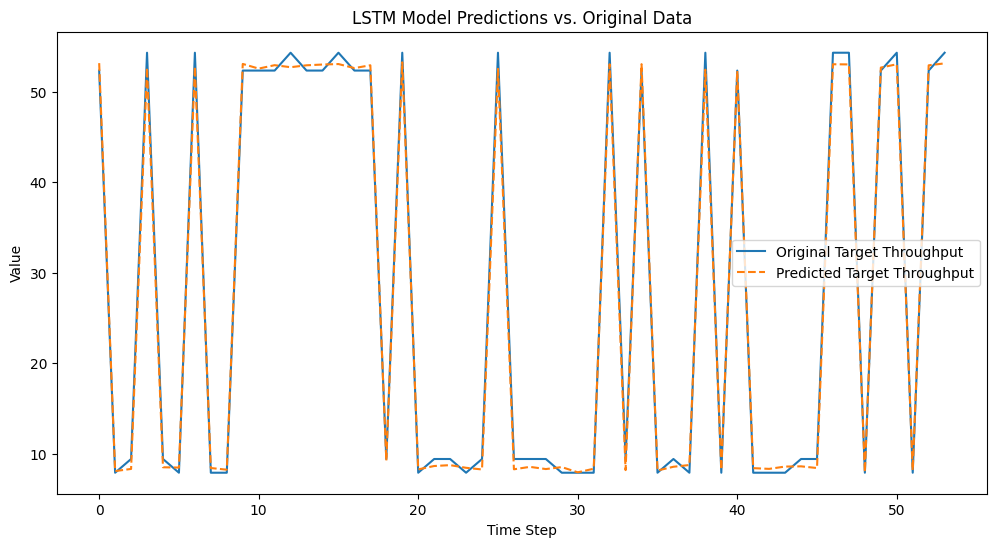

In [100]:
# model = torch.load("model_w10_i4_o1_h50_l1.pth", pickle_module=dill)
# Predicted outputs
model.eval()

x = []
y = []
p = []
for i, test_data_ in enumerate(test_data, 0):
    inputs, targets = test_data_
    X_ = inputs.to(device)
    Y_ = targets.to(device)
    x.extend(inputs)
    y.extend(targets)
    # print(targets)
    predicted = model(X_).to("cpu").detach().numpy()
    p.extend(predicted)
    r2 = r2_score(targets, predicted)
    print(f"R² Score: {r2:.4f}")

y = y[::100]
p = p[::100]

print(len(y))
print(len(p))
time_steps = np.arange(0, len(y))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y, label='Original Target Throughput')
plt.plot(time_steps, p, label='Predicted Target Throughput', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()